<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# 🛍️ Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products will sell more. 

## 📚 Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [1]:
# YOUR CODE HERE
import pandas as pd
past = pd.read_csv('../dat/past.csv.gz')
print (past.columns)

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')


<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

2. What percentage of the interactions (rows) resulted in a purchase?

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?
    
    From the perspective of classification, is the data balanced?

In [2]:
# YOUR CODE HERE
print (f'{100*past["Purchased?"].sum() / len(past):.1f}% of transactions resulted in a purchase.')

# There is an imbalance, but it is not a huge problem. We still have plenty of both Purchased and Did not Purchase examples

34.4% of transactions resulted in a purchase.


3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [3]:
# YOUR CODE HERE
# YOUR CODE HERE
X = past.drop(['product_id', 'user_id', 'Purchased?'], axis=1)
y = past['Purchased?']


In [4]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to a numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

In [5]:
from sklearn.preprocessing import StandardScaler
import pickle
scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X)
pickle.dump(scaler, open('scaler.pickle', 'wb'))


In [6]:
# YOUR CODE HERE
from sklearn.decomposition import PCA
pca = PCA(n_components = 5, whiten=True)
X_reduced = pca.fit_transform(X_rescaled)
print ('Explained variance ratio:', pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))


Explained variance ratio: [0.10282141 0.09445833 0.06514609 0.05134184 0.04154835] 0.35531600804610275


In [7]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

In [8]:
# YOUR CODE HERE
print ('Percentage of variance explained:', pca.explained_variance_ratio_, 'Overall:', sum(pca.explained_variance_ratio_))

Percentage of variance explained: [0.10282141 0.09445833 0.06514609 0.05134184 0.04154835] Overall: 0.35531600804610275


6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [9]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [10]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

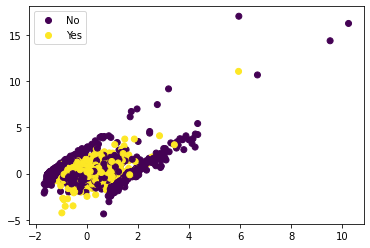

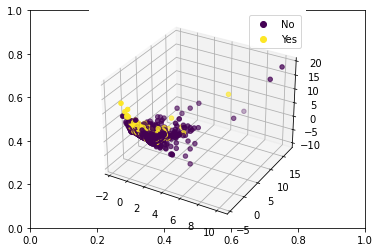

In [11]:
visualize_2pcs(X_reduced, y)
visualize_3pcs(X_reduced, y)


# YOUR CODE HERE

7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( are the labels balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [12]:
# YOUR CODE HERE (imports!)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def train(X, y, standardize = True) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 42)
    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
    
    model = LogisticRegression(class_weight = 'balanced')
    model.fit(X_train, y_train)
    
    report = classification_report(y_valid, model.predict(X_valid))    
    print (report)
    # YOUR CODE HERE    

Now apply the pipeline on the all the features `X` and review the performance

In [13]:
# YOUR CODE HERE
train(X, y, True)

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       656
           1       0.56      0.58      0.57       344

    accuracy                           0.70      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.70      0.70      0.70      1000



Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

In [14]:
# YOUR CODE HERE
train(X_reduced, y, False)

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       656
           1       0.50      0.54      0.52       344

    accuracy                           0.66      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.67      0.66      0.66      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 
    *YOUR ANSWER HERE*

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [15]:
# YOUR CODE HERE
from sklearn.cluster import k_means


2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [16]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        inertias.append(k_means(X, n_clusters = k, random_state=10)[-1])
        
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

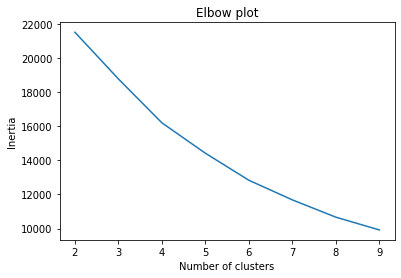

In [17]:
# YOUR CODE HERE
visualize_elbow(X_reduced, range(2, 10, 1))

4. What are the disadvantage to use the Elbow method? 

    *YOUR ANSWER HERE*
    From my experience, there are two main distavantages:
    - Sometimes you cannot point out the elbow clearly, it is ambiguous
    - The location of elbow depends havily of the scale of x axis. If you test the algorithm for 2-9 clusters, your elbow may be completely elswhere comparing to let's say testing the algorithm for 4-11 clusters

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [18]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.2003172289119776
For n_clusters = 3 The average silhouette_score is : 0.21112572909753416
For n_clusters = 4 The average silhouette_score is : 0.21982127237806418
For n_clusters = 5 The average silhouette_score is : 0.22611698883452924
For n_clusters = 6 The average silhouette_score is : 0.1944994282105026
For n_clusters = 7 The average silhouette_score is : 0.19602012159190044
For n_clusters = 8 The average silhouette_score is : 0.21168678330859347


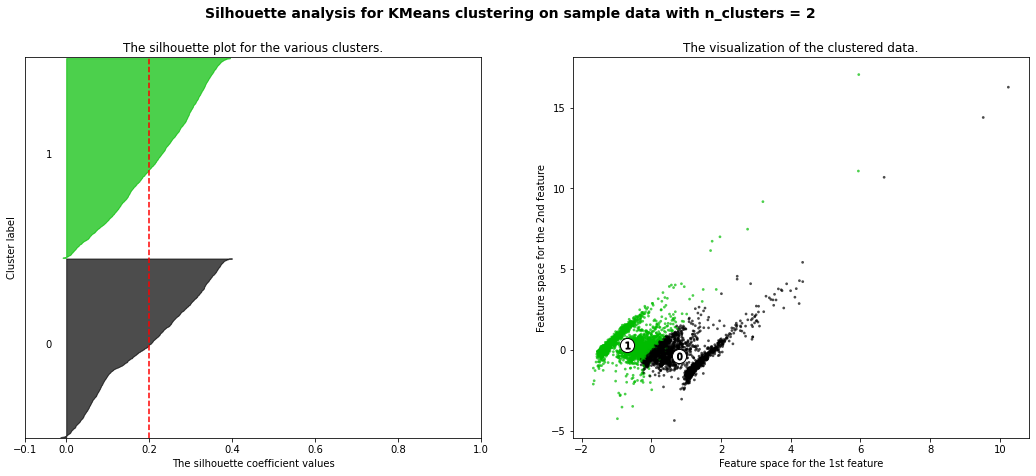

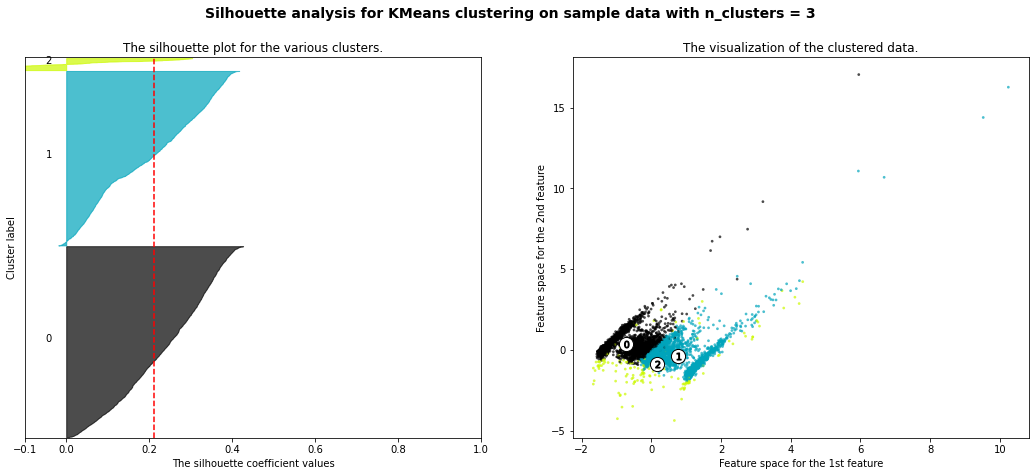

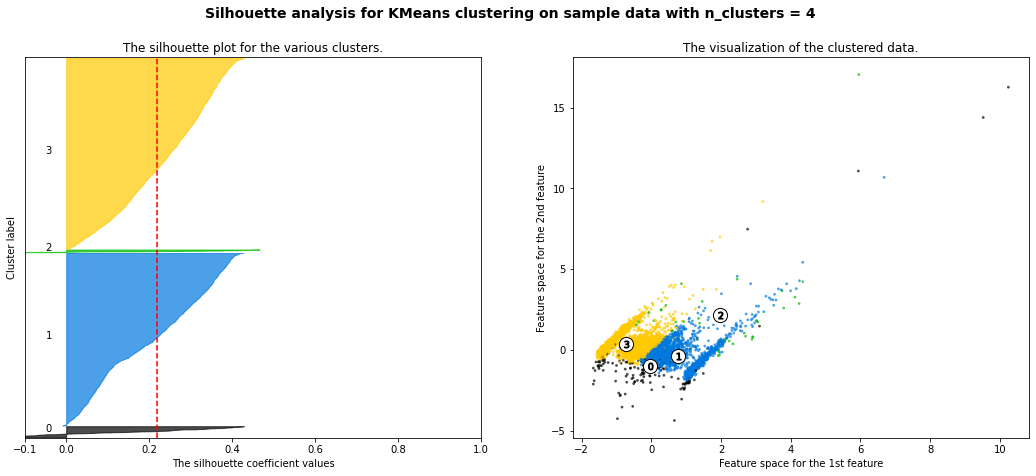

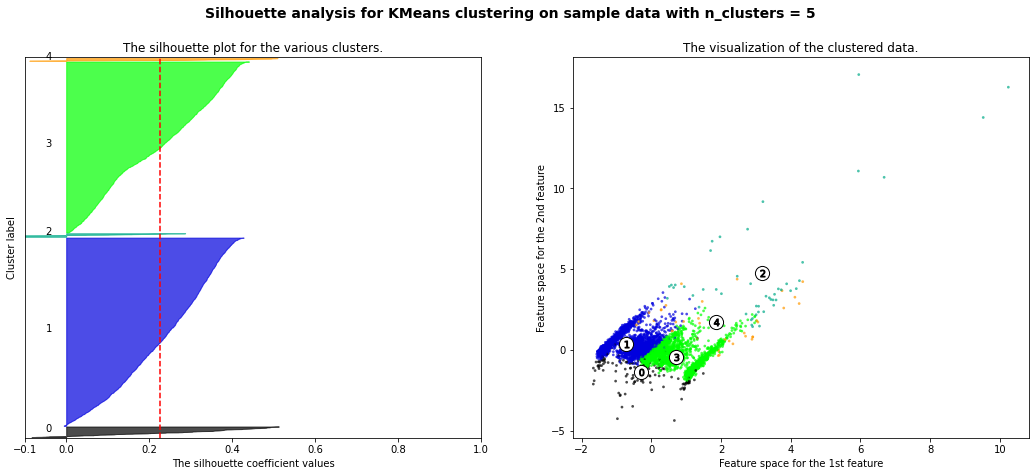

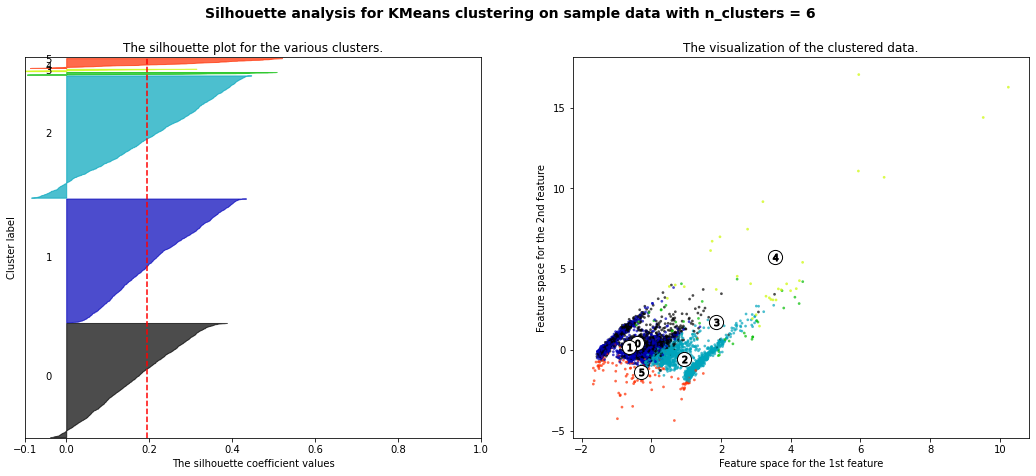

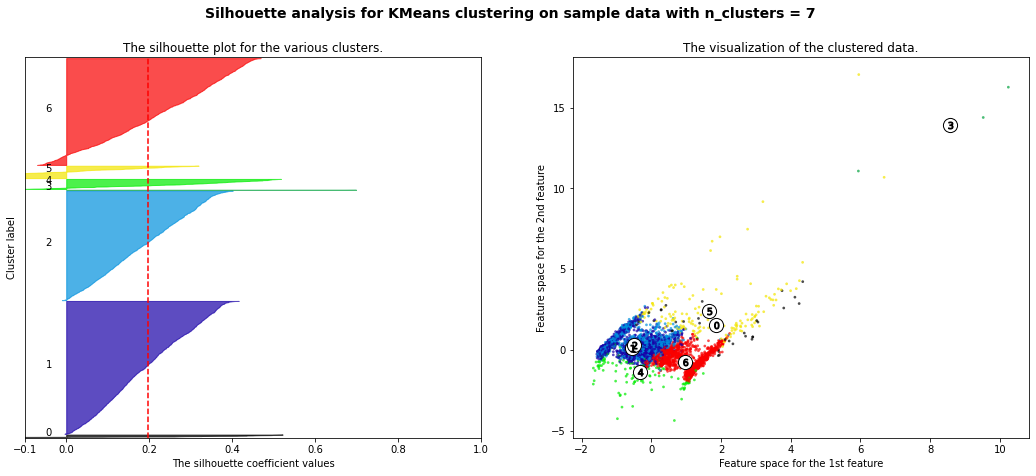

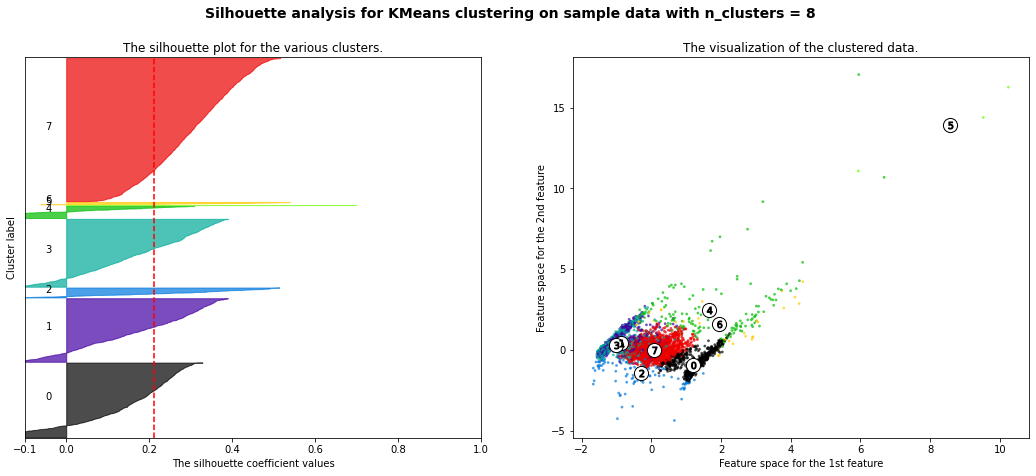

In [19]:
# YOUR CODE HERE
visualize_silhouette(max_clusters=8, X=X_reduced)

6. Instantiate a k-means model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [20]:
# YOUR CODE HERE
km = k_means(X_reduced, n_clusters = 4)

7. What is the size of each cluster? 

In [21]:
# YOUR CODE HERE
import numpy as np
unique, counts = np.unique(km[1], return_counts=True)
for u, c in zip(unique, counts):
    print (f'Cluster {u} contains {c} elements.')

Cluster 0 contains 2289 elements.
Cluster 1 contains 2531 elements.
Cluster 2 contains 37 elements.
Cluster 3 contains 143 elements.


8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [22]:
# YOUR CODE HERE
past['cluster_pca'] = km[1]
past.head()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0,0
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0,0
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0,0
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0,0
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0,1


9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

    *YOUR ANSWER HERE*

In [23]:
# YOUR CODE HERE
tmp = past.groupby('cluster_pca').describe().T
tmp.head(16)

cluster_pca                  0             1             2             3
product_id count  2.289000e+03  2.531000e+03  3.700000e+01  1.430000e+02
           mean   5.605948e+06  5.546096e+06  5.857353e+06  5.473643e+06
           std    1.106351e+06  1.201530e+06  6.673337e+04  1.419408e+06
           min    4.185000e+03  4.104000e+03  5.711723e+06  5.379000e+03
           25%    5.771073e+06  5.750782e+06  5.825438e+06  5.795839e+06
           50%    5.839093e+06  5.823509e+06  5.884465e+06  5.862712e+06
           75%    5.884228e+06  5.863013e+06  5.904710e+06  5.893196e+06
           max    5.932538e+06  5.916644e+06  5.931329e+06  5.931773e+06
user_id    count  2.289000e+03  2.531000e+03  3.700000e+01  1.430000e+02
           mean   5.324278e+08  5.150345e+08  4.965749e+08  5.383940e+08
           std    5.979630e+07  5.906295e+07  9.046696e+07  4.319250e+07
           min    1.219156e+08  6.524181e+07  1.319941e+08  3.924473e+08
           25%    5.070392e+08  4.939104e+08  4.624029e+08  5.196468e+08
           50%    5.401916e+08  5.283095e+08  4.975934e+08  5.464919e+08
           75%    5.714647e+08  5.559828e+08  5.682334e+08  5.669192e+08
           max    6.220262e+08  5.971146e+08  6.099770e+08  6.151285e+08

In [24]:
tmp.loc[['minPrice', 'maxPrice'], :]

cluster_pca               0            1          2           3
minPrice count  2289.000000  2531.000000  37.000000  143.000000
         mean      6.230501     5.642873   4.364459   58.925792
         std       5.851413     5.194944   4.091700   34.286814
         min       0.000000     0.000000   0.000000    1.350000
         25%       2.520000     2.380000   1.430000   39.010000
         50%       4.520000     4.130000   3.756667   47.600000
         75%       7.460000     6.797000   6.380000   64.825000
         max      39.520000    33.810000  17.460000  236.510000
maxPrice count  2289.000000  2531.000000  37.000000  143.000000
         mean      6.263258     5.665881   4.789414   58.977978
         std       5.868213     5.199260   3.872665   34.290084
         min       0.000000     0.000000   0.000000    1.590000
         25%       2.540000     2.380000   1.590000   39.010000
         50%       4.600000     4.140000   4.020000   47.600000
         75%       7.460000     6.830000   6.380000   64.846186
         max      39.520000    33.810000  17.460000  236.510000

In [25]:
# Actually this is nice, we manage to define a cluster 
# of goods that are generally not being purchased :)
# From the business perspective, this may be very useful.
tmp.loc['Purchased?', :]

cluster_pca,0,1,2,3
count,2289.000000,2531.000000,37.000000,143.000000
mean,0.330275,0.356776,0.054054,0.405594
std,0.470415,0.479143,0.229243,0.492733
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


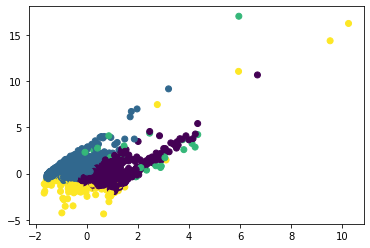

In [26]:
f = plt.figure()
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=past.cluster_pca);

10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

    *YOUR ANSWER HERE*
1. What are the assumptions for k-means?

The basic assumptions of k-means are:
- you need to choose the number of clusters arbitrarily
- every data point belongs to strictly one cluster.

2. Is k-means a good approach?

This is a very general question. K-means a quite old, and very popular algorithm. It if fast, easy to understand, and requires relatively little knowledge about the dataset. If I want to do clustering, and I am not very familiar with my data, K-means is probably my first choice. The downsides of k-means are twofold:
- you have to choose the number of clusters. Well, with every clustering algorithm you have to define something, but yet it may be annoying
- It is not deterministic. You can solve this problem partly, by running the algorithm many times and using some smart ways of selecting starting points (like K-means++), but when it comes to really large datasets, this is a drawback.
- It is prone to outliers. They can change the clustering results heavily.
- It cannot detect outliers. By definition, all the points are members of a cluster.
- It doesn't work well with some type of datasets. If the clusters are not linearly separable, k-means behaves poorly.

I would not judge any clustering algorithm based on the cluster sizes only. Imbalanced sizes may be a flaw of the algorithm or just a story that is told by the data.





In [28]:
# YOUR CODE HERE
pd.DataFrame(X_reduced).describe()

,0,1,2,3,4
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,-3.090861e-17,6.827872e-18,-2.122885e-17,-5.895284e-18,-5.684342e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.661649e+00,-4.372859e+00,-9.690877e+00,-9.884243e+00,-8.097160e+00
25%,-7.588293e-01,-5.088973e-01,-4.219236e-01,-4.188016e-01,-4.814238e-01
50%,-5.901978e-02,-3.490663e-02,-1.436745e-01,-1.653428e-01,-4.096176e-03
75%,6.508883e-01,4.093024e-01,1.981511e-01,1.495678e-01,4.877839e-01
max,1.024241e+01,1.704094e+01,1.904259e+01,1.937700e+01,1.562612e+01


In [50]:
# Note - I ran this many times to determine the hyperparameters. 
# I am still not good with the results, but they are 
# informative at least.

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples = 15)
dbclusters = dbscan.fit_predict(X_reduced)

past['dbclusters'] = dbclusters
past.groupby('dbclusters').describe().T.loc['Purchased?', :]


dbclusters,-1,0,1
count,1314.000000,3673.000000,13.0
mean,0.202435,0.395589,0.0
std,0.401968,0.489044,0.0
min,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.0
75%,0.000000,1.000000,0.0
max,1.000000,1.000000,0.0


11. Jot down recommendations or followup steps, detailing the reasons.

    *YOUR ANSWER HERE*
Regarding db-scan - I managed to divide data into two subsets. In the first subset (not clustered) the probability of purchase is twice as small as in the second subset (cluster 0). Using this, we may analyze new products and assign them to one of two groups (unlikely/likely to be purchased). The second cluster contains outliers and it should be disregarded.

Of course, this is only the first step, the following steps are as follows:
- Split the data into train/valid subsets, redo the clustering and check if this approach makes sense. Actually, this is a necessary step. I did not do it due to the logic of this assignment, and to be consistent with what we were doing during the class.
- Check if it is possible to cluster the data even further. For instance, using different parameters, I managed to create more clusters (some of them even with 90% probability of purchase). However, these clusters were too small to be useful from the business perspective. Thus, I decided to go with the presented split. Anyway, in a business project I would invest more time in clustering before going to the next steps.
- Consult with the stakeholders. At this stage, the results should be presented to the business clients (weekly meeting), and the feedback should be collected. One of the most important feedbacks would be about the accuracy metrics and business expectations ("what does it mean good solution" and "how good is good enough"). I would determine the next steps based on such a feedback.


## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [186]:
# YOUR CODE HERE
new = pd.read_csv('../dat/new.csv.gz')
print (new.shape)
print (new.columns)
new.head()

(30091, 5)
Index(['product_id', 'maxPrice', 'minPrice', 'Purchased?', 'Category'], dtype='object')


,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


In [207]:
# Note - this is surprising, Category has
# 724 unique values, so it cannot be considered
# categorical feature. I am adding it here, 
# because in the first attempt I tried to 
# consider it categorical feature.
len(new.Category.unique())


724

In [208]:
assert new.shape == (30091, 5)

In [209]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

        *YOUR ANSWER HERE*

Guys, you already provided your answer to this question. I agree with you, so I am leaving your answer as is :).

    *The number of datapoints in the training set is relatively small while the test set is quite large. The training set has more features than in the test set.*

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [210]:
# YOUR CODE HERE
np.intersect1d(past.product_id, new.product_id)

# Sanity check :)
#new[new.product_id.isin(past.product_id)]

array([], dtype=int64)

4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [211]:
# YOUR CODE HERE # ~.344
new['Purchased?'].mean()

0.3442557575354757

5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [212]:
# YOUR CODE HERE

# Note. This task is ambiguous. I am not sure
# if I should split new subset into train/test
# merge past and new subsets and then split,
# or just consider that past is train and new
# is test. Based on the asserts from the next
# cells I assumed the last option, but it is not
# clear to me.


train_cols = ['maxPrice', 'minPrice', 'Category']
label_col = 'Purchased?'
#from sklearn.model_selection import train_test_split

#X = new[['maxPrice', 'minPrice', 'Category']].to_numpy()
#y = new['Purchased?'].to_numpy()

#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.1, stratify=y, random_state=42)

X_train = past[train_cols].to_numpy()
X_test = new[train_cols].to_numpy()
y_train = past[label_col].to_numpy()
y_test = new[label_col].to_numpy()


print ('X train shape:', X_train.shape)
print ('X test shape:', X_test.shape)
print ('y train shape:', y_train.shape)
print ('y test shape:', y_test.shape)



X train shape: (5000, 3)
X test shape: (30091, 3)
y train shape: (5000,)
y test shape: (30091,)


In [213]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [214]:
# Note: I want to use pipelines, so let me use
# dataframes instead of numpy arrasys

X_train = past[train_cols]
X_test = new[train_cols]
y_train = past[label_col]
y_test = new[label_col]



In [215]:
# YOUR CODE HERE
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ['maxPrice', 'minPrice', 'Category']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ]
)

In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr_model = LogisticRegression(class_weight = 'balanced', max_iter=500)
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("model", lr_model)]
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print (classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091



7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [217]:
# YOUR CODE HERE


#X = pd.concat([X_train, X_test, past[X_train.columns]], ignore_index=True).to_numpy()
X = pd.concat([X_train, X_test], ignore_index=True)

In [218]:
assert X.shape == (35091, 3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [219]:
# YOUR CODE HERE
y = np.array(list(y_train) + [-1] * (len(X) - len(y_train)))         

In [220]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [221]:
# YOUR CODE HERE
from sklearn.semi_supervised import LabelSpreading
ls_model = LabelSpreading(kernel='knn', alpha=0.01)
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#ls_model.fit(X, y)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("model", ls_model)]
)

model.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['maxPrice', 'minPrice',
                                                   'Category'])])),
                ('model', LabelSpreading(alpha=0.01, kernel='knn'))])

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [222]:
semi_sup_preds = ls_model.transduction_
print('Sanity check. Everything is OK:', 
      (y[:len(X_train)] == semi_sup_preds[:len(X_train)]).all())
semi_sup_preds = semi_sup_preds[len(X_train):]


Sanity check. Everything is OK: True


In [223]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [224]:
from sklearn.metrics import classification_report

print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     19732
           1       0.85      0.68      0.75     10359

    accuracy                           0.85     30091
   macro avg       0.85      0.81      0.82     30091
weighted avg       0.85      0.85      0.84     30091



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [225]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091



    *YOUR ANSWER HERE*
    
Areas for improvement:
- this solution could be improved generally, but in the beginning I would focus on improving recall, especially for labels=1. 
- It could be done in many ways, I would start with building model cascades (outputs from one model are used as an inpur for another model), and/or with some bagging/busting methods

Reasons for improvement:
- This is a business question: Generally speaking we may approach this twofold. If launching new products is cheap, we do not want to skip any opportunity, thus we need to push recall as high as possible, simultaneously trying to keep precision on a certain level (for example, how good we can go with recall given the precision is at least 80%). On the other hand, if the cost of launching a new product is high, and we have many options, we want to push the precision as high as possible. This way, we may expect that if we decide to launch a new product, we will succeed.



11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)